In [1]:
library("DESeq2")
library("biomaRt")
dir_counts <- "~/ABABhwk/Unit2-RNAseq/data/htseq_out/day5"
counts_files <- list.files(dir_counts)
samplesInfo <- as.data.frame(matrix(ncol=2, nrow=length(counts_files)))  
samplesInfo$samplename <- counts_files  
samplesInfo$filename <- counts_files  
samplesInfo$group <- c("mock", "ZIKV", "mock", "ZIKV", "mock", "ZIKV") 
#Remove the blank columns
samplesInfo <- samplesInfo[,-c(1:2)]
dds1 <- DESeqDataSetFromHTSeqCount(sampleTable = samplesInfo, 
                                           directory = dir_counts, 
                                           design = ~ group)
#### Run the main DESeq normalization and analysis function
dds1_deseq <- DESeq(dds1)
rld <- rlog(dds1_deseq)
vsd <- varianceStabilizingTransformation(dds1_deseq)
res <- results(dds1_deseq, contrast=c("group", "ZIKV", "mock"))
summary(res)
resSorted <- res[order(res$padj),]
# EMSEMBL ids 
bm <- useMart(biomart = "ensembl")
bm <- useDataset(dataset = "hsapiens_gene_ensembl", mart = bm)
ens2genesymbol <- getBM(mart = bm, attributes = c('ensembl_gene_id', 'external_gene_name'))


Loading required package: S4Vectors
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: ‘BiocGenerics’

The following objects are masked from ‘package:parallel’:

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from ‘package:stats’:

    IQR, mad, sd, var, xtabs

The following objects are masked from ‘package:base’:

    anyDuplicated, append, as.data.frame, basename, cbind, colMeans,
    colnames, colSums, dirname, do.call, duplicated, eval, evalq,
    Filter, Find, get, grep, grepl, intersect, is.unsorted, lapply,
    lengths, Map, mapply, match, mget, order, paste, pmax, pmax.int,
    pmin, pmin.int, Position, rank, rbind, Reduce, rowMeans, rownames,
    rowSums, sapply, setdiff, sort, table, tapply, union, unique,
    unsplit, which, which.max, which


out of 37609 with nonzero total read count
adjusted p-value < 0.1
LFC > 0 (up)       : 461, 1.2%
LFC < 0 (down)     : 476, 1.3%
outliers [1]       : 9, 0.024%
low counts [2]     : 20516, 55%
(mean count < 24)
[1] see 'cooksCutoff' argument of ?results
[2] see 'independentFiltering' argument of ?results



## Installing libraries
```
if (!requireNamespace("BiocManager", quietly = TRUE))
    install.packages("BiocManager")
BiocManager::install("org.Hs.eg.db", version = "3.8")
BiocManager::install("clusterProfiler", version = "3.8")
```

In [3]:
library(clusterProfiler)
library(org.Hs.eg.db)


clusterProfiler v3.10.0  For help: https://guangchuangyu.github.io/software/clusterProfiler

If you use clusterProfiler in published research, please cite:
Guangchuang Yu, Li-Gen Wang, Yanyan Han, Qing-Yu He. clusterProfiler: an R package for comparing biological themes among gene clusters. OMICS: A Journal of Integrative Biology. 2012, 16(5):284-287.

Attaching package: ‘clusterProfiler’

The following object is masked from ‘package:DelayedArray’:

    simplify

Loading required package: AnnotationDbi



## Volcano Plot
Let's redo the volcano plot we had used before. 

This time however let's highlight the differentially expressed genes with a **fold change >= 2** and **p-value <= 0.01**.

Let's remove NAs from resSorted$padj

In [4]:
resFilteredSorted <- resSorted[complete.cases(resSorted$padj),]
dim(resFilteredSorted)

[1] 17084     6

Let's create a column "selected" an set value to **TRUE** or **FALSE** based on whether they satisfy our conditions.

In [5]:
resFilteredSorted[,"selected"] <- FALSE
resFilteredSorted[resFilteredSorted$padj <= 0.01 & abs(resFilteredSorted$log2FoldChange) >= 1, "selected"] <- TRUE

Let's now plot the volcano plot. log2Foldchange on the xaxis and -log10(padj) on yaxis.

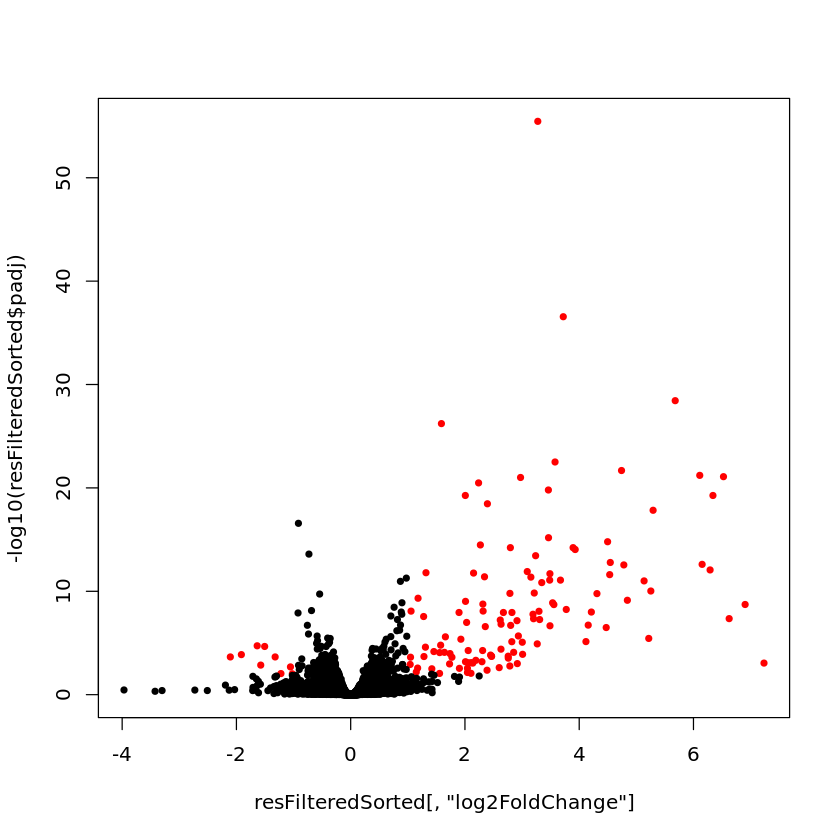

In [6]:
plot(resFilteredSorted[,"log2FoldChange"], -log10(resFilteredSorted$padj), col=as.factor(resFilteredSorted$selected), pch=20)

Let's try and plot the text for each gene. We've already retrieved the symbol for the ENSEMBL id using the *getBM()* function in the bioMart package.

In [7]:
# Select rows from resFilteredSort that match out conditions.
df.selected <- resFilteredSorted[resFilteredSorted$padj <= 0.01 & abs(resFilteredSorted$log2FoldChange) >= 1,]
# Loop over ens2genesymbol dataframe that was created before to get the gene name for each ENSEMBL ID
df.labels <- sapply(rownames(df.selected), function(x){
    ens2genesymbol[ens2genesymbol["ensembl_gene_id"]==x,"external_gene_name"]
})

Now let's plot!

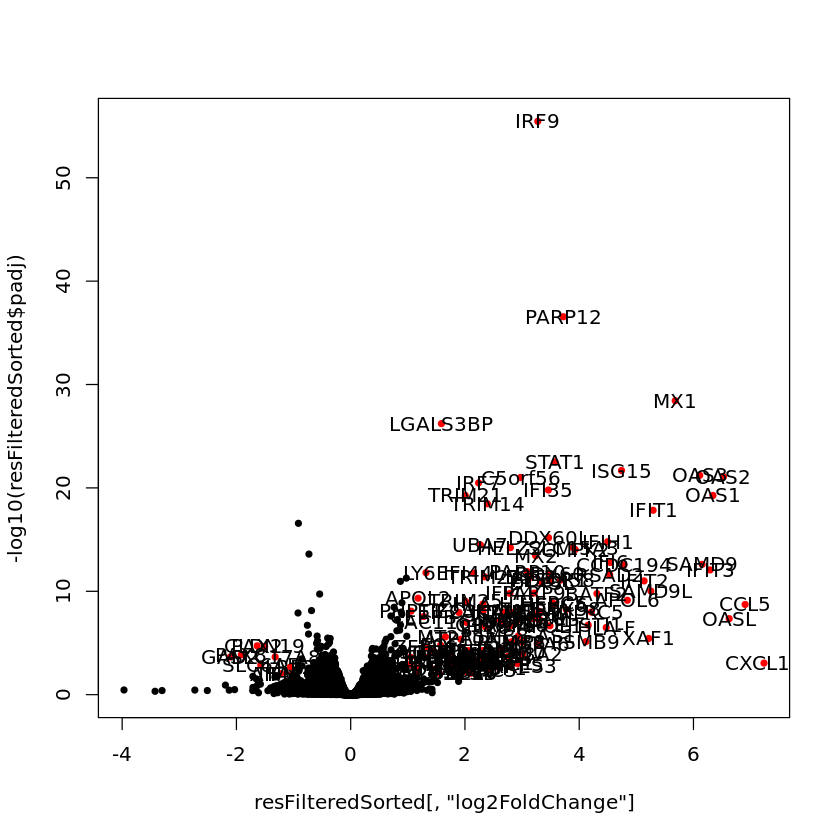

In [8]:
plot(resFilteredSorted[,"log2FoldChange"], -log10(resFilteredSorted$padj), col=as.factor(resFilteredSorted$selected), pch=20)
text(df.selected[,"log2FoldChange"], -log10(df.selected$padj), labels = df.labels)

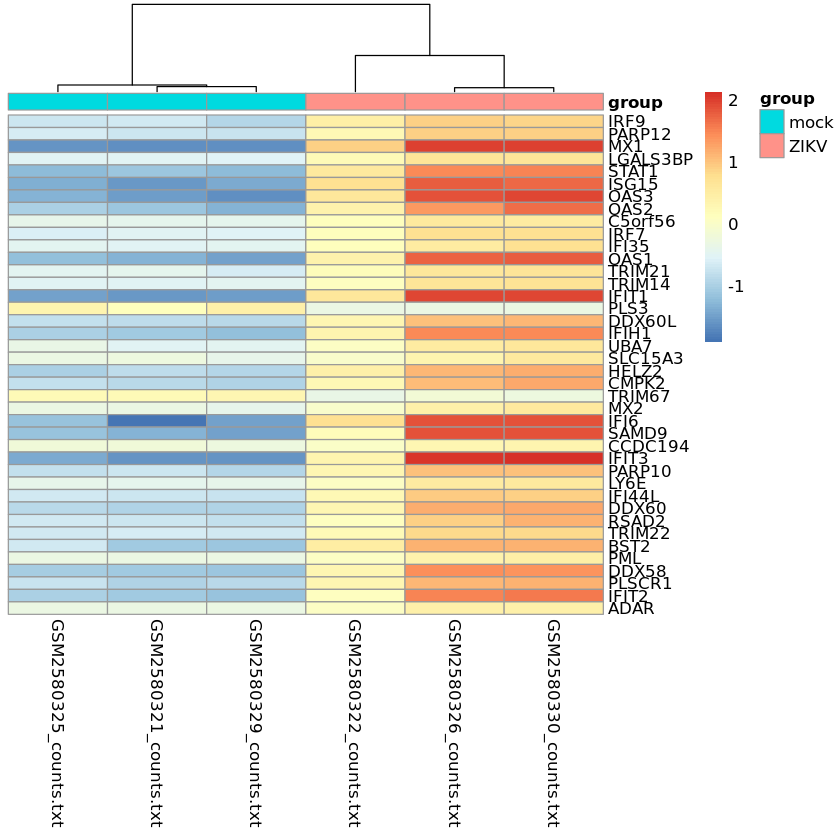

In [9]:
library(pheatmap)
df <- data.frame(colData(rld)[,"group"])
rownames(df) <- rownames(colData(rld))
colnames(df) <- c("group")

ngenes <- 40
deg <- rownames(resSorted)[1:ngenes]
mat <- assay(rld)[deg,]
mat <- mat - rowMeans(mat)
rownames(mat) <- sapply(rownames(resSorted)[1:ngenes], function(x){
    return(ens2genesymbol[ens2genesymbol[,"ensembl_gene_id"]==x,"external_gene_name"]);
})

pheatmap(mat,
        annotation_col = df,
        cluster_cols = T,
        cluster_rows=F)

## Go enrichment

Let's now map the ENSEMBL ids to GO ids using the *bitr()* function.

In [10]:
gomap <- bitr(rownames(resFilteredSorted), "ENSEMBL", "GO", org.Hs.eg.db, drop = TRUE)

'select()' returned 1:many mapping between keys and columns
Warning message in bitr(rownames(resFilteredSorted), "ENSEMBL", "GO", org.Hs.eg.db, :
“20.9% of input gene IDs are fail to map...”

Let's now select the unique EMSEMBL and GO id pairs from the Molecular Function(MF) domain.

In [11]:
gomap.f <- gomap[gomap$ONTOLOGY=="MF",]
gomap.f <- unique(gomap.f[,c("ENSEMBL", "GO")])

In [12]:
head(gomap.f)

,ENSEMBL,GO
1,ENSG00000213928,GO:0000978
2,ENSG00000213928,GO:0000981
5,ENSG00000213928,GO:0003700
6,ENSG00000213928,GO:0005515
18,ENSG00000059378,GO:0003723
19,ENSG00000059378,GO:0003950


Let's now get the human readable descriptions of the GO ids.

In [13]:
gomap.descriptions <- go2term(unique(gomap.f$GO))
head(gomap.descriptions)

go_id,Term
GO:0044183,protein binding involved in protein folding
GO:0051082,unfolded protein binding
GO:0003756,protein disulfide isomerase activity
GO:0015036,disulfide oxidoreductase activity
GO:0000010,trans-hexaprenyltranstransferase activity
GO:0000014,single-stranded DNA endodeoxyribonuclease activity


Let's now create a new column, "GO_TERM" in the gomap.f dataframe and add the description there.

In [14]:
gomap.f$GO_TERM <- sapply(gomap.f$GO, function(x){
    return(gomap.descriptions[gomap.descriptions$go_id==x,"Term"]);
})

In [15]:
head(gomap.f)

,ENSEMBL,GO,GO_TERM
1,ENSG00000213928,GO:0000978,RNA polymerase II proximal promoter sequence-specific DNA binding
2,ENSG00000213928,GO:0000981,"DNA-binding transcription factor activity, RNA polymerase II-specific"
5,ENSG00000213928,GO:0003700,DNA-binding transcription factor activity
6,ENSG00000213928,GO:0005515,protein binding
18,ENSG00000059378,GO:0003723,RNA binding
19,ENSG00000059378,GO:0003950,NAD+ ADP-ribosyltransferase activity


Let's get a table of the counts of each GO term

In [16]:
gomap.f.table <- table(gomap.f$GO_TERM)
# Sort table by count
gomap.f.table <- gomap.f.table[order(gomap.f.table, decreasing=TRUE)]

Let's make a piechart of the top 20 GO terms using the table!

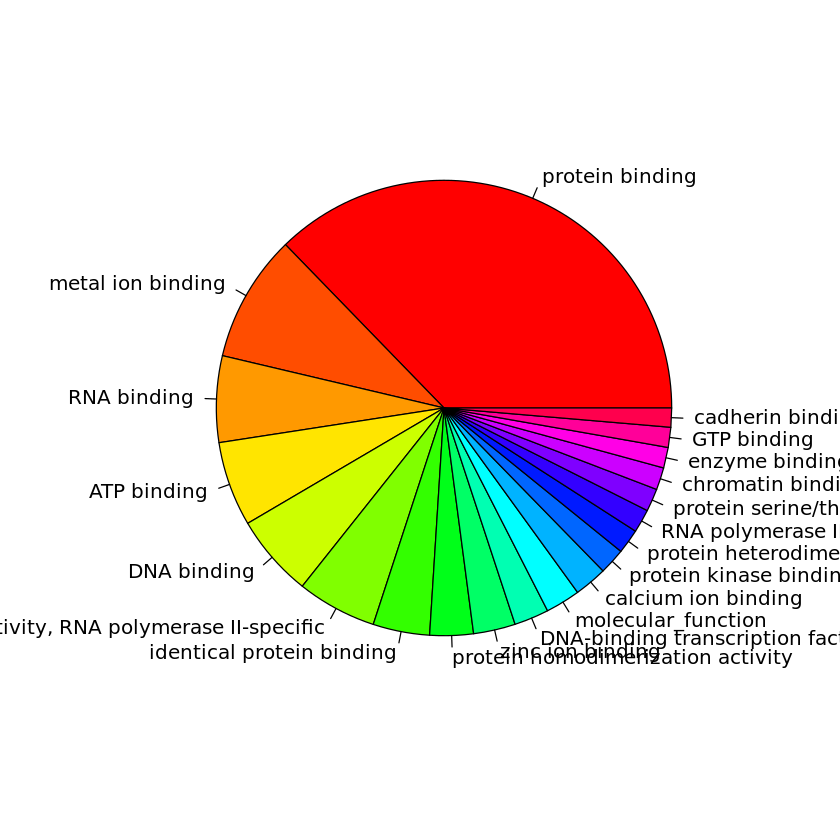

In [17]:
# raindow is just a colorscheme.
pie(gomap.f.table[1:20], col = rainbow(20))